# Self-supervised and multi-modal representation Learning: Notebook 2

Here we will build a simple encoder for light curves, and try to train it to learn useful representation via masked autoencoding (i.e., predicting a missing part of the light curve).

## Light curve encoding via masked self-supervised learning

In [9]:
import sys, os
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data loading and pre-processing

Let's start by loading the BTS data. The data contain variable number of light curves. For those with >100 observations pick 100 at random. Pad the shorter ones with zeros up to a length of 100. We'll also create a padding mask to be used in the encoder.

In [ ]:
# data_dir = "../data/ZTFBTS/"  # If unzipped locally
data_dir = "/ocean/projects/phy230064p/shared/ZTFBTS/" # If running on Bridges-2

In [163]:
dir_light_curves = f"{data_dir}/light-curves/"

def open_light_curve_csv(filename):
    """ Helper function to open a light curve csv file.
    """
    file_path = os.path.join(dir_light_curves, filename)
    df = pd.read_csv(file_path)
    return df

n_max_obs = 100

# Open all light curves and save as list. Pad observations with zeros up to n_max_obs.
mag = np.zeros((len(os.listdir(dir_light_curves)), n_max_obs))
time = np.zeros((len(os.listdir(dir_light_curves)), n_max_obs))
mask = np.zeros((len(os.listdir(dir_light_curves)), n_max_obs), dtype=bool)

band = 'R'  # Only keep r-band for now

idx = 0
for filename in os.listdir(dir_light_curves):
    if filename.endswith(".csv"):
        df = open_light_curve_csv(filename)
        ds = df[df['band'] == band]
        # If less than n_max_obs observations, pad with zeros
        if len(df['mag']) < n_max_obs:
            mag[idx, :len(df['mag'])] = df['mag']
            time[idx, :len(df['mag'])] = df['time']
            mask[idx, :len(df['mag'])] = 1
        # Otherwise, randomly select n_max_obs observations
        else:
            rand_idx = np.random.choice(len(df['mag']), n_max_obs, replace=False)
            mag[idx, :] = df['mag'][rand_idx]
            time[idx, :] = df['time'][rand_idx]
            mask[idx, :] = 1
        idx += 1

### Light curve encoder

We'll start with a simple transformer-based light curve encoder. Since transformers are inherenently permutation-equivariant (i.e., insensitive to ordering -- a permutation of the inputs leads to a corresponding permutation of the outputs), we'll need to add time encodings to "tell" the transformer the time corresponding to each observation. 

This is a simple way to be able to deal with variable-length, heterogeneously sampled light curves. There are many extensions to this basic idea, see e.g.
- https://arxiv.org/abs/2309.16316
- https://arxiv.org/abs/2308.06404
- https://www.aanda.org/articles/aa/full_html/2023/02/aa43928-22/aa43928-22.html

and feel free to implement ideas from these or others, e.g. learnable time encoding bases.

In [164]:
# ! pip install lightning

In [165]:
import math

import torch
import torch.nn as nn
import pytorch_lightning as pl

from models.transformer_utils import Transformer

PyTorch has a boilerplate Transformer implementation (`nn.TransformerEncoder`), but we'll use a lower-level implementation in `models/transformer_utils.py` for a bit more flexibility if we need it. Feel free to play around with either in the block below, inspecting the outputs and their shape, effect of masking, effect of changing hyperparameters.

In [166]:
# # Transformer from torch.nn
# encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
# transformer = nn.TransformerEncoder(encoder_layer, num_layers=6,)

# Our transformer from models/transformer_utiles.py
transformer = Transformer(emb=128, heads=2, depth=2, ff_hidden_mult=4)  # Instantiate

# Dummy inputs
mask_test = torch.ones((1, 100), dtype=torch.bool)
x = torch.randn((1, 100, 128))

# Forward pass
transformer(x, mask_test)

tensor([[[ 0.7169, -0.0152, -0.2081,  ...,  0.2847, -0.4700,  0.5192],
         [-0.8863, -0.2498,  0.4566,  ...,  0.6930, -1.1997,  0.2941],
         [-0.8571,  1.7139, -0.2165,  ..., -0.1036,  0.9106,  0.2390],
         ...,
         [-0.8888, -1.4006, -1.8667,  ...,  0.8689, -1.4223,  0.0686],
         [ 0.1094,  1.3390,  0.8329,  ...,  0.5157, -1.0801,  1.2060],
         [-1.0780, -0.9443, -0.6452,  ..., -1.1107, -0.7308,  0.6656]]],
       grad_fn=<NativeLayerNormBackward0>)

Now let's implement the light curve encoder. For more details on the time-encoding via fourier features, please see e.g., [here](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#Positional-encoding), from where it was adapted. We'll include the time encoding dependence simply by adding the embeddings to the linear embeddings of individual light curve data points.

In [167]:
class TimePositionalEncoding(nn.Module):
    """ Time encodings for Transformer. 
    """

    def __init__(self, d_emb):
        """
        Inputs
            d_emb - Dimensionality when projecting to the fourier feature basis.
        """
        super().__init__()
        self.d_emb = d_emb

    def forward(self, t):
        pe = torch.zeros(t.shape[0], t.shape[1], self.d_emb).to(t.device)  # (B, T, D)
        div_term = torch.exp(torch.arange(0, self.d_emb, 2).float() * (-math.log(10000.0) / self.d_emb))[None, None, :].to(t.device)  # (1, 1, D / 2)
        t = t.unsqueeze(2)  # (B, 1, T)
        pe[:, :, 0::2] = torch.sin(t * div_term)  # (B, T, D / 2)
        pe[:, :, 1::2] = torch.cos(t * div_term)  # (B, T, D / 2)
        return pe  # (B, T, D)

class TransformerWithTimeEmbeddings(nn.Module):
    """ Transformer encoer.
    """

    def __init__(self, n_out=1, **kwargs):
        """
        :param n_out: Number of outputs per sequence element (e.g., number of bands).
        :param kwargs: Transformer arguments.
        """
        super().__init__()
        
        self.embedding_mag = nn.Linear(in_features=1, out_features=kwargs['emb'])
        self.embedding_t = TimePositionalEncoding(kwargs['emb'])
        self.transformer = Transformer(**kwargs)
        self.projection = nn.Linear(in_features=kwargs['emb'], out_features=n_out)

    def forward(self, x, t, mask=None):
        """
        :param x: Input sequence (B, T, 1).
        :param t: Time sequence (B, T).
        :param mask: Padding mask (B, T).
        :return: Output sequence (B, T, n_out).
        """
        t = t - t[:, 0].unsqueeze(1)  # (B, T)  # Relative time
        t_emb = self.embedding_t(t)  # (B, T, D)  # Project to embedding dimension of transformer
        x = self.embedding_mag(x) + t_emb  # (B, T, D)  # Add time embeddings to magnitude embeddings
        x = self.transformer(x, mask)  # (B, T, D)  # Transformer
        x = self.projection(x)  # (B, T, n_out)  # Project each sequence element (independently) to output dim

        return x

transformer = TransformerWithTimeEmbeddings(n_out=1, emb=128, heads=2, depth=2)

### Dataset prep and masking

In [168]:
# Convert to torch tensors
mag = torch.Tensor(mag)
time = torch.Tensor(time)
mask = torch.Tensor(mask).to(torch.bool)

# Standardize mag
mag_mean = mag.mean()
mag_std = mag.std()
mag = (mag - mag_mean) / mag_std

# # Standardize time # Don't standardize time, since we'll zero-subtract for simplicity
# time_mean = time.mean()
# time_std = time.std()
# time = (time - time_mean) / time_std

Write a convenience function to get masks for the encoder.

In [169]:
# Convenience function to get random masks

def get_random_mask(padding_mask, f_mask=0.15):
    """ Get a random contiguous masks for the input sequence.
    :param padding_mask: Padding mask (B, T).
    :param f_mask: Fraction of mask to keep.
    :return: Mask (B, T).
    """
    mask = torch.ones_like(padding_mask)
    mask_pred = torch.ones_like(padding_mask)
    for i in range(padding_mask.shape[0]):
        n_obs = padding_mask[i].sum().item()
        n_obs_to_keep = int(n_obs * f_mask)
        start = torch.randint(0, n_obs - n_obs_to_keep + 1, (1,)).item()
        end = start + n_obs_to_keep

        # Mask containing observations to be kept
        mask[i, start:end] = False  # Mask out observations from start to end
        mask[i, n_obs:] = False

        # Mask only containing observations to be predicted
        mask_pred[i, end:n_obs] = False
        mask_pred[i, :start] = False
        mask_pred[i, start:end] = True
        mask_pred[i, n_obs:] = False
        
    return mask, mask_pred

# Test the mask function

f_mask = 0.15

mask_test = mask[1244:]
mask_in, mask_pred = get_random_mask(mask_test, f_mask=f_mask)  # Mask out 15% of observations

Mask


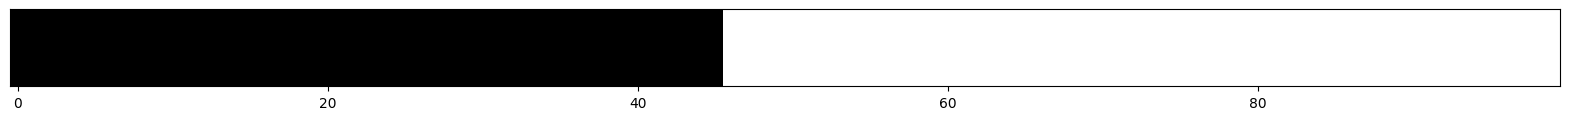

Mask in: original mask with 0.15 of observations masked out


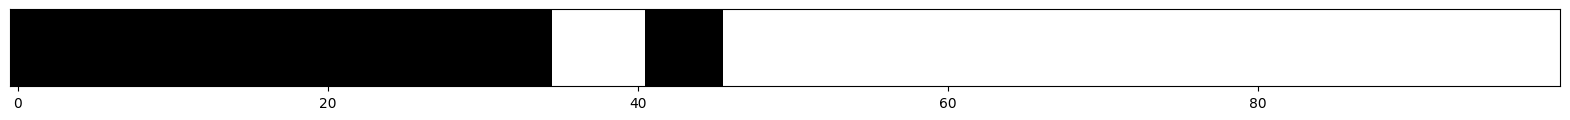

Mask pred: observations to be predicted


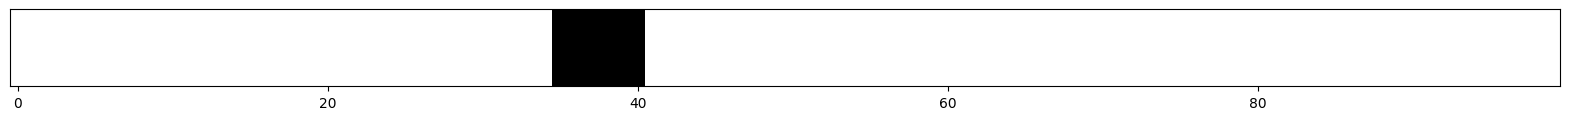

In [170]:
# Function to plot a mask
def plot_mask(mask):
    """ `mask` is a 1D boolean array.
    """
    plt.figure(figsize=(20, 1))
    plt.imshow(mask[None, :], aspect='auto', cmap='binary', vmin=0, vmax=1)
    plt.yticks([])
    plt.show()

print("Mask")
plot_mask(mask_test[0].detach().numpy())

print(f"Mask in: original mask with {f_mask} of observations masked out")
plot_mask(mask_in[0].detach().numpy())

print("Mask pred: observations to be predicted")
plot_mask(mask_pred[0].detach().numpy())

Let's pass a small batch through our lightcurve encoder.

In [171]:
n_small_batch = 4

out = transformer(mag[:n_small_batch].unsqueeze(-1), time[:n_small_batch], mask[:n_small_batch])  # Unsqueeze just adds a channel dimension (B, T, 1)
out.shape

torch.Size([4, 100, 1])

### Train masked autoencoder

In [216]:
class MaskedLightCurveEncoder(pl.LightningModule):
    def __init__(self, f_mask=0.2, transformer_kwargs={"n_out":1, "emb":128, "heads":2, "depth":4}, optimizer_kwargs={}, lr=1e-3):
        super().__init__()

        self.optimizer_kwargs = optimizer_kwargs
        self.lr = lr
        self.f_mask = f_mask

        self.net = TransformerWithTimeEmbeddings(**transformer_kwargs)

    def forward(self, x, t, mask=None):
        x = x[..., None]
        x = self.net(x, t, mask)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.RAdam(self.parameters(), lr=self.lr, **self.optimizer_kwargs)
        return {"optimizer": optimizer}

    def masked_pred(self, x, t, padding_mask, f_mask=0.15):
        # Get random mask and predict with masked inputs; then, return only the unmasked outputs
        mask_in, mask_pred = get_random_mask(padding_mask, f_mask=f_mask)
        x_masked = x.clone()
        x_masked[~mask_in] = 0
        x_pred = self(x_masked, t, mask=padding_mask)[..., 0]  
        return x[mask_pred], x_pred[mask_pred]
    
    def training_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("train_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

    def validation_step(self, batch, batch_idx):
        x, t, padding_mask = batch
        x, x_pred = self.masked_pred(x, t, padding_mask, f_mask=self.f_mask)
        loss = nn.MSELoss()(x, x_pred)
        self.log("val_loss", loss, on_epoch=True, on_step=False, prog_bar=True,)
        return loss

In [217]:
mlce = MaskedLightCurveEncoder(f_mask=0.15, lr=6e-4, transformer_kwargs={"n_out":1, "emb":256, "heads":4, "depth":12, "dropout":0.02})

In [218]:
from torch.utils.data import TensorDataset, DataLoader, random_split

val_fraction = 0.05
batch_size = 64
n_samples_val = int(val_fraction * mag.shape[0])

dataset = TensorDataset(mag, time, mask)

dataset_train, dataset_val = random_split(dataset, [mag.shape[0] - n_samples_val, n_samples_val])
train_loader = DataLoader(dataset_train, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=batch_size, num_workers=8, pin_memory=True, shuffle=False)

In [219]:
trainer = pl.Trainer(max_epochs=30, accelerator='gpu',)
trainer.fit(model=mlce, train_dataloaders=train_loader, val_dataloaders=val_loader)

Trainer will use only 1 of 8 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=8)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name | Type                          | Params
-------------------------------------------------------
0 | net  | TransformerWithTimeEmbeddings | 9.5 M 
-------------------------------------------------------
9.5 M     Trainable params
0         Non-trainable params
9.5 M     Total params
37.875    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 77/77 [00:05<00:00, 13.63it/s, v_num=2.18e+7]    
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 77/77 [00:05<00:00, 13.01it/s, v_num=2.18e+7, val_loss=0.0287, train_loss=0.179]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 77/77 [00:05<00:00, 13.03it/s, v_num=2.18e+7, val_loss=0.0242, train_loss=0.024]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 77/77 [00:05<00:00, 13.05it/s, v_num=2.18e+7, val_loss=0.0131, train_loss=0.0174]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 77/77 [00:05<00:00, 12.99it/s, v_num=2.18e+7, val_loss=0.00894, train_loss=0.0155]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 77/77 [00:05<00:00, 12.99it/s, v_num=2.18e+7, val_loss=0.0126, train_loss=0.0125] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 77/77 [00:05<00:00, 13.03it/s, v_num=2.18e+7, val_loss=0.0137, train_loss=0.00978]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 77/77 [00:06<00:00, 11.42it/s, v_num=2.18e+7, val_loss=0.00439, train_loss=0.00493]


### Evaluation: mask-filling

In [220]:
mlce = mlce.eval()

Let's see how well the encoder can fill in the masked parts of the light curves (set to zero, the special mask token) for the validation set.

In [223]:
mag_test, time_test, mask_test = next(iter(val_loader))

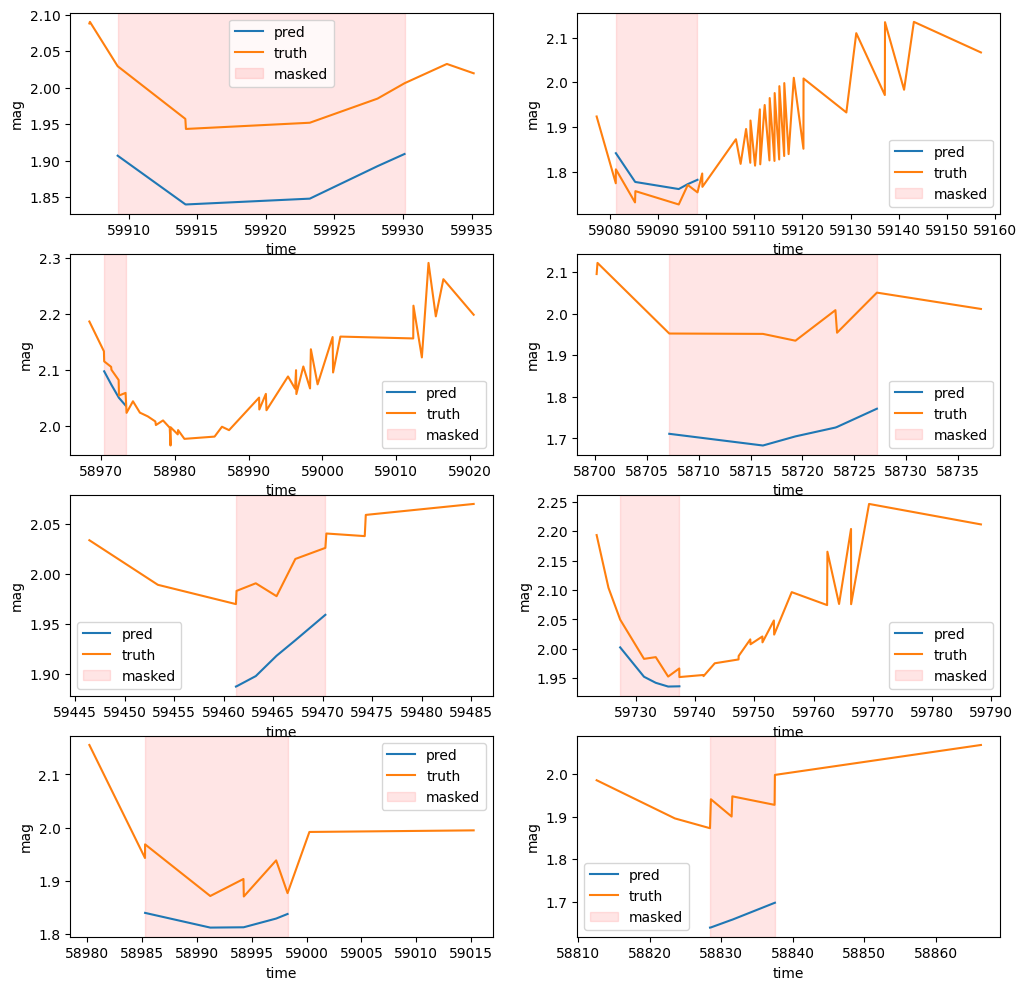

In [224]:
fig, ax = plt.subplots(4, 2, figsize=(12, 12))

for i in range(4):
    for j in range(2):
        ii = i * 2 + j

        fill_min, fill_max = 2, 7  # Mask out observations from fill_min to fill_max
        mask_tofill = mask_test[ii:ii + 1].clone()
        mask_tofill[:, fill_min:fill_max + 1] = False

        # Remove zero-padded, masked out elements
        mag_truth = mag_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]
        mag_test_in = mag_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]
        time_test_in = time_test[ii:ii + 1].clone()[mask_test[ii:ii + 1]]

        mag_test_in[fill_min:fill_max + 1] = 0

        mag_pred = mlce(mag_test_in[None, ...], time_test_in[None, ...],)[0, :, 0].detach().numpy()[fill_min:fill_max + 1]

        ax[i, j].plot(time_test_in[fill_min:fill_max + 1], mag_pred, label='pred')
        ax[i, j].plot(time_test_in, mag_truth, label='truth')

        # Mark the masked observations; if fill_[min/max] is bigger than the number of observations, make it the length of the observations
        fill_min = min(fill_min, len(time_test_in) - 1)
        fill_max = min(fill_max, len(time_test_in) - 1)
        
        ax[i, j].axvspan(time_test_in[fill_min], time_test_in[fill_max], alpha=0.1, color='red', label='masked')
        ax[i, j].legend()

        ax[i, j].set_xlabel('time')
        ax[i, j].set_ylabel('mag')

Not great, but that was a very simple model. There seems to be an overall offset in the predictions! Can you improve the model and/or dataset? E.g.,
- We've standardized the light curves, so we don't have any information about their overall amplitude. That could explain the overall offset we're seeing above. How can you include this information in the model?
- We're only using r-band magnitudes. Can you use all available bands?
- Can you include information about magnitude errors?
- Can you improve the way time is embedded into the transformer (see references above)?